In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [2]:
# Download stopwords if not already present
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aarushisharma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

In [4]:
# Load and preprocess data
df = pd.read_csv("msd_dataset_with_only_clean_lyrics.csv")
df = df[~df['genre'].isna() & ~df['lyrics'].isna()]
stopwords_set = set(stopwords.words('english'))

In [5]:
def clean_lyrics(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())
    tokens = text.split()
    return ' '.join([t for t in tokens if t not in stopwords_set])

In [6]:
df['cleaned_lyrics'] = df['lyrics'].apply(clean_lyrics)
genre_counts = df['genre'].value_counts()
valid_genres = genre_counts[genre_counts >= 20].index
df = df[df['genre'].isin(valid_genres)]

In [7]:
# Dynamically downsample overly dominant genres
threshold = 0.3 * len(df)  # e.g., no class should take more than 30% of the data
balanced_dfs = []
for genre, count in df['genre'].value_counts().items():
    genre_df = df[df['genre'] == genre]
    if count > threshold:
        genre_df = resample(genre_df, replace=False, n_samples=int(threshold), random_state=SEED)
    balanced_dfs.append(genre_df)
df = pd.concat(balanced_dfs).sample(frac=1, random_state=SEED)

In [8]:
# Tokenization
tokenized = df['cleaned_lyrics'].apply(str.split)
w2v_model = Word2Vec(sentences=tokenized, vector_size=50, window=5, min_count=3, workers=4)
valid_words = set(w2v_model.wv.index_to_key)

In [9]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_lyrics'])
filtered_index = {word: i+1 for i, word in enumerate(valid_words)}
tokenizer.word_index = filtered_index
tokenizer.index_word = {i: word for word, i in filtered_index.items()}

In [10]:
# Create sliding windows
def create_sliding_windows(seq, window_size=100, step_size=50):
    windows = []
    for start in range(0, len(seq) - window_size + 1, step_size):
        windows.append(seq[start:start+window_size])
    if not windows and len(seq) > 0:
        windows.append(seq[:window_size])
    return windows

In [11]:
X_seq = []
y_seq = []
labels = df['genre'].tolist()
tokenized_seqs = tokenizer.texts_to_sequences(df['cleaned_lyrics'])

In [12]:
for i, seq in enumerate(tokenized_seqs):
    windows = create_sliding_windows(seq, window_size=100, step_size=50)
    for window in windows:
        padded = pad_sequences([window], maxlen=100)[0]
        X_seq.append(padded)
        y_seq.append(labels[i])

In [14]:
X = np.array(X_seq)
le = LabelEncoder()
y_labels = le.fit_transform(y_seq)
y = to_categorical(y_labels)

In [15]:
embedding_matrix = np.zeros((len(filtered_index) + 1, 50))
for word, i in filtered_index.items():
    embedding_matrix[i] = w2v_model.wv[word]

In [16]:
# Metadata features
meta_features = ['duration','tempo','key','loudness'] + [
    f'pitch_mean_{i}' for i in range(12)
] + [f'pitch_std_{i}' for i in range(12)] + [f'timbre_mean_{i}' for i in range(12)] + [f'timbre_std_{i}' for i in range(12)]
df[meta_features] = df[meta_features].fillna(0)
scaler = StandardScaler()
# Expand metadata to align with sliding windows
meta_rows = []
for i, seq in enumerate(tokenized_seqs):
    windows = create_sliding_windows(seq, window_size=100, step_size=50)
    num_windows = len(windows)
    meta_row = df.iloc[i][meta_features].values
    for _ in range(num_windows):
        meta_rows.append(meta_row)

In [17]:
X_meta_all = np.array(meta_rows)
X_meta_all = scaler.fit_transform(X_meta_all)

In [18]:
# Split
test_size = 0.3
val_size = 0.5
X_train_lyrics, X_temp_lyrics, X_train_meta, X_temp_meta, y_train, y_temp, y_train_labels, y_temp_labels = train_test_split(
    X, X_meta_all, y, y_labels, test_size=test_size, stratify=y_labels, random_state=SEED
)
X_val_lyrics, X_test_lyrics, X_val_meta, X_test_meta, y_val, y_test, y_val_labels, y_test_labels = train_test_split(
    X_temp_lyrics, X_temp_meta, y_temp, y_temp_labels, test_size=val_size, stratify=y_temp_labels, random_state=SEED
)

In [19]:
# Build and train LSTM model
input_lyrics = Input(shape=(100,))
x = Embedding(input_dim=embedding_matrix.shape[0], output_dim=50,
              weights=[embedding_matrix], trainable=False)(input_lyrics)
x = Bidirectional(LSTM(64))(x)
x = Dropout(0.3)(x)

In [20]:
input_meta = Input(shape=(X_train_meta.shape[1],))
combined = Concatenate()([x, input_meta])
output = Dense(y.shape[1], activation='softmax')(combined)

In [21]:
model = Model(inputs=[input_lyrics, input_meta], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# Early stopping
early = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
history = model.fit([X_train_lyrics, X_train_meta], y_train,
          validation_data=([X_val_lyrics, X_val_meta], y_val),
          batch_size=64, epochs=20, callbacks=[early], verbose=1)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.1061 - loss: 2.7373 - val_accuracy: 0.2671 - val_loss: 2.2058
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.2730 - loss: 2.1378 - val_accuracy: 0.3675 - val_loss: 1.9298
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.3383 - loss: 1.9672 - val_accuracy: 0.3782 - val_loss: 1.8135
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.3777 - loss: 1.8540 - val_accuracy: 0.4338 - val_loss: 1.6985
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.4329 - loss: 1.7211 - val_accuracy: 0.4487 - val_loss: 1.6392
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.4597 - loss: 1.6431 - val_accuracy: 0.4744 - val_loss: 1.6148
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.4784 - loss: 1.5892 - val_accuracy: 0.4850 - val_loss: 1.5615
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.4854 - loss: 1.5792 - val_accuracy: 0.4808 -

In [23]:
# Evaluate
y_pred = np.argmax(model.predict([X_test_lyrics, X_test_meta]), axis=1)
y_true = y_test_labels

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [24]:
test_acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy on held-out set: {test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

Test Accuracy on held-out set: 0.4979

Classification Report:
              precision    recall  f1-score   support

       Blues       0.81      0.57      0.67        30
     Country       0.50      0.13      0.21        15
  Electronic       0.75      0.27      0.40        22
        Folk       1.00      0.25      0.40         4
        Jazz       0.27      0.09      0.14        32
       Latin       0.10      0.10      0.10        10
       Metal       0.56      0.60      0.58        25
         Pop       0.30      0.41      0.35        69
        Punk       0.17      0.11      0.13         9
         Rap       0.70      0.86      0.77        93
      Reggae       0.75      0.55      0.63        33
         RnB       1.00      0.36      0.53        11
        Rock       0.39      0.50      0.44       115

    accuracy                           0.50       468
   macro avg       0.56      0.37      0.41       468
weighted avg       0.52      0.50      0.49       468



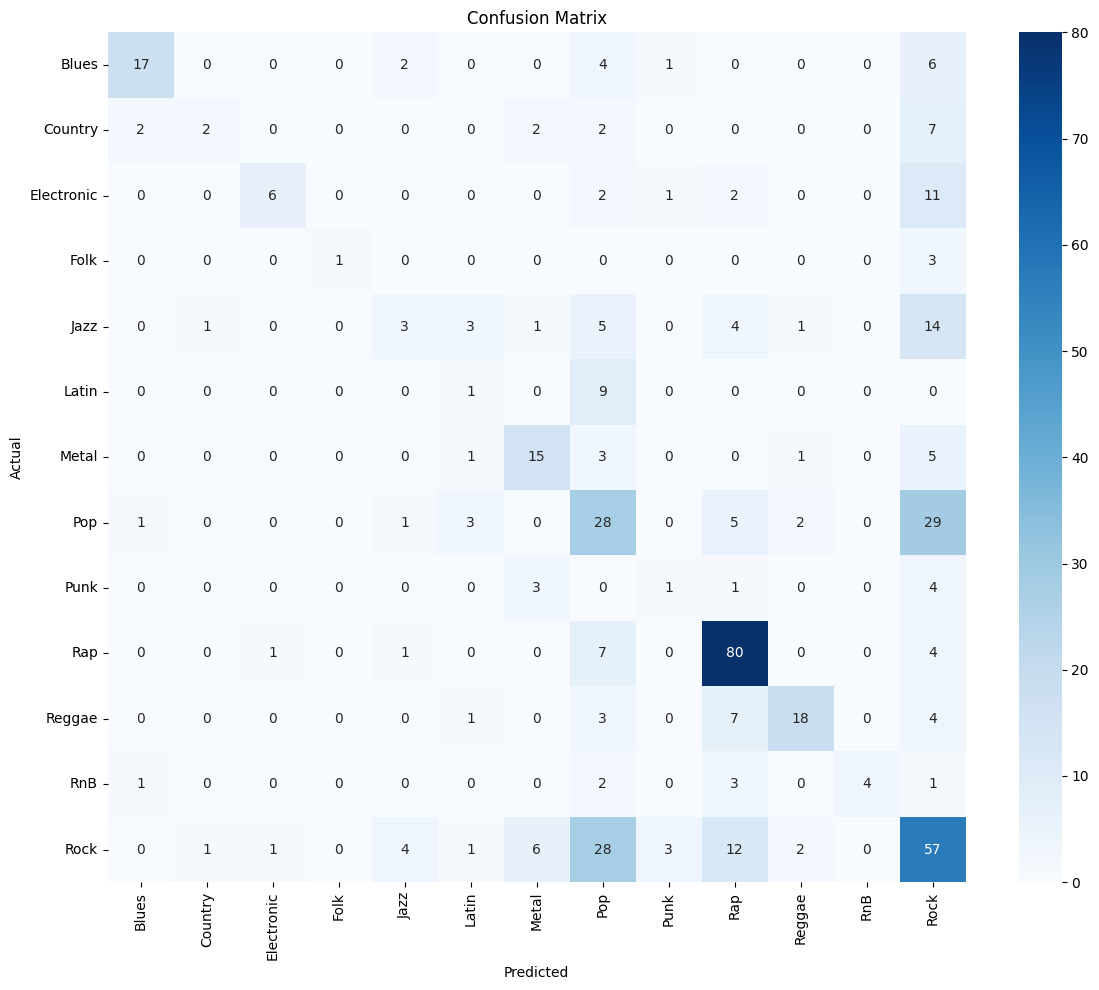

In [25]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [26]:
# Random sample of predictions vs actual
sample_idxs = np.random.choice(len(X_test_lyrics), size=5, replace=False)
for i in sample_idxs:
    actual = le.inverse_transform([y_test_labels[i]])[0]
    predicted = le.inverse_transform([y_pred[i]])[0]
    print(f"\nSample {i}")
    print("Actual Genre   :", actual)
    print("Predicted Genre:", predicted)


Sample 55
Actual Genre   : Metal
Predicted Genre: Metal

Sample 63
Actual Genre   : Rap
Predicted Genre: Rap

Sample 33
Actual Genre   : Rock
Predicted Genre: Rock

Sample 297
Actual Genre   : Latin
Predicted Genre: Latin

Sample 72
Actual Genre   : Jazz
Predicted Genre: Rock
